## Question 0: Getting real data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from operator import itemgetter
from collections import Counter
import math
import statistics as stats
import matplotlib.pyplot as plt

dataUrl = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
rawData = urllib.request.urlopen(dataUrl)
dataHeaders = ['code_number', 'clump_thickness', 'cell_size', 'cell_shape', 'marginal_adhesion', 'single_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']



data = np.genfromtxt(rawData, delimiter=',', dtype=int, missing_values={6:'?'}, filling_values={6:4})


split = math.ceil(len(data) * .80)

trainingData, testData = data[:split], data[split:]
y_train = [i[10] for i in trainingData]

# Need to keep this around to check if accurate
x_train = [i[10] for i in testData] 

trainingData = np.delete(trainingData, 10, axis=1)
testData = np.delete(testData, 10, axis=1)

trainingData = np.delete(trainingData, 0, axis=1)
testData = np.delete(testData, 0, axis=1)

### Question 0
For the missing data values in the 7th column which is the Bare Nuclei, I decided to fill in the ? values with the average of the entire column, which I found to be 3.5.  I rounded up to 4 to keep things consistent with the rest of the values given to us.
I also deleted the first column since it was unnecessary for our calculations.

## Question 1: k-Nearest Neighbor Classifier

In [25]:
"""
Function to find distance between two vectors
"""
def LP_distance(x,y,p):
    totalDistance = 0
    for i,j in zip(x,y):
        newDistance = (abs(i-j)**p)
        totalDistance += newDistance
    return (totalDistance**(1/p))


"""
Function gets k neighbors for one tuple
"""
def get_k_neighbors(trainingData, testTuple, y_train, k, p):
    allDistances = []
    trainCnt = 0
    for dataEntry in trainingData:
        newDistance = LP_distance(dataEntry, testTuple, p)
        allDistances.append((newDistance, y_train[trainCnt]))
        trainCnt += 1
    allDistances = sorted(allDistances, key=itemgetter(0))
    
    kDistances = [val[1] for val in allDistances[:k]]
    return kDistances
    

def knn_classifier(x_test, x_train, y_train, k, p):
    y_pred = []
    
    for testValue in x_test:
        
        neighbors = get_k_neighbors(x_train, testValue, y_train, k, p)
        countClass = list(Counter(neighbors).keys())
        y_pred.append(countClass[0])
    
    return y_pred


result = knn_classifier(testData, trainingData, y_train, 2, 1)

sameCount = 0
for i,j in zip(x_train, result):
    if i == j:
        sameCount += 1

print(sameCount/len(x_train) * 100)
        





98.56115107913669


### Question 1
My knn_classifier first obtains a list of k neighbors and sorts it by distances in order to return the k nearest neighbors.  I tested the accuracy of my classifier using a 80/20 split and I got around a 97% accuracy without randomizing the dataset.

## Question 2: Evaluation

### Splitting up the data into 10 sections

In [26]:
np.random.shuffle(data)


splitData = data[:]

#splitData = [data[i:i + split_ten] for i in range(0, len(data), split_ten)]

count = 0
rand_y_train = [i[10] for i in splitData]
splitData = np.delete(splitData, 10, axis=1)
splitData= np.delete(splitData, 0, axis=1)   

### Defining all of our functions for our metrics

In [27]:
def testAccuracy(y_pred, y_actual):
    sameCount = 0
    for i,j in zip(y_pred, y_actual):
        if i == j:
            sameCount += 1
    accuracy = (sameCount/len(y_actual)) * 100
    return accuracy

def testSensitivity(y_pred, y_actual):
    tp_count = 0
    fn_count = 0
    for i,j in zip(y_pred, y_actual):
        if i == 4 and j == 4:
            tp_count += 1
        if i == 2 and j == 4:
            fn_count += 1
        
    sensitivity = tp_count/(tp_count + fn_count) * 100
    return sensitivity

def testSpecificity(y_pred, y_actual):
    tn_count = 0
    fp_count = 0
    for i,j in zip(y_pred, y_actual):
        if i == 2 and j == 2:
            tn_count += 1
        if i == 4 and j == 2:
            fp_count += 1
    specificity = tn_count/(tn_count + fp_count) * 100
    return specificity

### Defining function for 10-fold cross validation

In [28]:
"""
Input:

splitData: Contains test data and training data split into 10 sections
y_train: Contains training data classes

Output:
y_splitPred: Contains test data classes

"""
def tenCrossValidation(totalData, total_y_train, k, p, accuracyList, sensitivityList, specificityList):
    
    y_predList = []
    split_ten = math.ceil(len(totalData)/10)
    currentPos = 0

    for current in range(10):
        # Getting the current slice of data to test on
        testData = totalData[currentPos:currentPos+split_ten]
        y_testClass = total_y_train[currentPos:currentPos+split_ten]

        # Getting the current data to be training from
        trainingData = []
        y_trainCopy = []

        if currentPos == 0:
            trainingData = totalData[currentPos+split_ten:]
            y_trainCopy = total_y_train[currentPos+split_ten:]

        elif currentPos+split_ten >= (len(totalData)-1):
            trainingData = totalData[0:currentPos]
            y_trainCopy = total_y_train[0:currentPos]


        else:
            a_train = totalData[0:currentPos]
            b_train = totalData[currentPos+split_ten:]

            trainingData = np.concatenate((a_train, b_train), axis=0)

            a_y = total_y_train[0:currentPos]
            b_y = total_y_train[currentPos+split_ten:]

            y_trainCopy = np.concatenate((a_y, b_y), axis=0)

        
        fresh_y_pred = knn_classifier(testData, trainingData, y_trainCopy, k, p)
        accuracy = testAccuracy(fresh_y_pred, y_testClass)
        sensitivity = testSensitivity(fresh_y_pred, y_testClass)
        specificity = testSpecificity(fresh_y_pred, y_testClass)
        
        accuracyList.append(accuracy)
        sensitivityList.append(sensitivity)
        specificityList.append(specificity)
        
        y_predList.append(fresh_y_pred)

        currentPos += split_ten
    return y_predList

### Gathering the results

In [29]:
# tenCrossValidation will return a list of lists containing the
# prediction for our knn algorithm

mAccuracyList = []
mSensitivityList = []
mSpecificityList = []

stAccuracyList = []
stSensitivityList = []
stSpecificityList = []
for p in range(2):
    # Sample mean lists
    mean_accuracy_list = []
    mean_sensitivity_list = []
    mean_specificity_list = []
    
    # Standard deviation lists
    stdev_accuracy_list = []
    stdev_sensitivity_list = []
    stdev_specificity_list = []
    for k in range(10):
        accuracyList = []
        sensitivityList = []
        specificityList = []
        
        y_predList = tenCrossValidation(splitData, rand_y_train, k+1,p+1, accuracyList, sensitivityList, specificityList)
        
        # Calculate Averages
        mean_accuracy = stats.mean(accuracyList)
        mean_sensitivity = stats.mean(sensitivityList)
        mean_specificity = stats.mean(specificityList)
        
        # Append to lists
        mean_accuracy_list.append(mean_accuracy)
        mean_sensitivity_list.append(mean_sensitivity)
        mean_specificity_list.append(mean_specificity)
        
        
        # Calculate Standard Deviations
        stdev_accuracy = stats.stdev(accuracyList)
        stdev_sensitivity = stats.stdev(sensitivityList)
        stdev_specificity = stats.stdev(specificityList)
        
        # Append to lists  
        stdev_accuracy_list.append(stdev_accuracy)
        stdev_sensitivity_list.append(stdev_sensitivity)
        stdev_specificity_list.append(stdev_specificity)
        
        # Delete references
        del accuracyList
        del sensitivityList
        del specificityList
        
    mAccuracyList.append(mean_accuracy_list)
    mSensitivityList.append(mean_sensitivity_list)
    mSpecificityList.append(mean_specificity_list)

    stAccuracyList.append(stdev_accuracy_list)
    stSensitivityList.append(stdev_sensitivity_list)
    stSpecificityList.append(stdev_specificity_list)

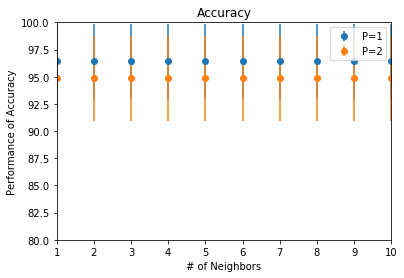

In [30]:
# Accuracy Plots

x_coor = list(range(1,11))

plt.figure(1)
plt.xlabel('# of Neighbors')
plt.ylabel('Performance of Accuracy')
plt.axis([1,10,80,100])
plt.errorbar(x_coor, mAccuracyList[0], yerr=stAccuracyList[0],fmt='o')
plt.errorbar(x_coor, mAccuracyList[1], yerr=stAccuracyList[1],fmt='o')
plt.legend(('P=1','P=2'))
plt.title("Accuracy")
plt.show()

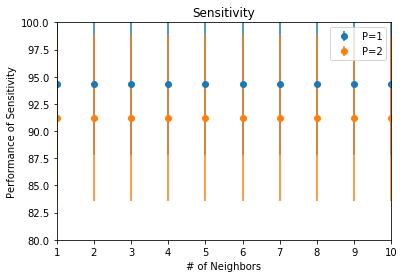

In [31]:
# Sensitivty Plots
x_coor = list(range(1,11))

plt.figure(1)
plt.xlabel('# of Neighbors')
plt.ylabel('Performance of Sensitivity')
plt.axis([1,10,80,100])
plt.errorbar(x_coor, mSensitivityList[0], yerr=stSensitivityList[0],fmt='o')
plt.errorbar(x_coor, mSensitivityList[1], yerr=stSensitivityList[1],fmt='o')
plt.legend(('P=1','P=2'))
plt.title("Sensitivity")
plt.show()



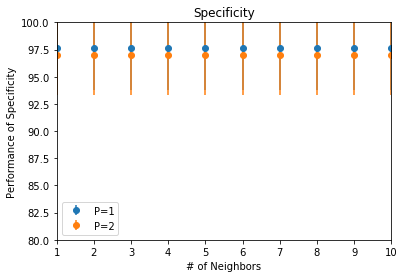

In [32]:
# Specificity Plots
x_coor = list(range(1,11))

plt.figure(1)
plt.xlabel('# of Neighbors')
plt.ylabel('Performance of Specificity')
plt.axis([1,10,80,100])
plt.errorbar(x_coor, mSpecificityList[0], yerr=stSpecificityList[0],fmt='o')
plt.errorbar(x_coor, mSpecificityList[1], yerr=stSpecificityList[1],fmt='o')
plt.legend(('P=1','P=2'))
plt.title("Specificity")
plt.show()

### Question 2

With the graphs shown above, it seems clear that choosing a value of p==1 gives us better performance for our classifier.  As for Ks, its not as lear but it seems choosing a neighbor amount of 3 gives us better performance for our classifier.  

## Sources

1. https://stackoverflow.com/questions/10695139/sort-a-list-of-tuples-by-2nd-item-integer-value
2. https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.delete.html
3. https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
4. https://docs.python.org/3/library/statistics.html
5. https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html